## Introduction  

Multi-Principal Element Alloys (MPEAs) represent an innovative class of materials engineered with multiple principal elements, often exhibiting exceptional mechanical properties like high yield strength. This project investigates whether machine learning models can reliably **predict yield strength** based on:  
- **Chemical composition** (elemental fractions)  
- **Microstructure** (phase configurations, e.g., BCC, FCC)  
- **Processing methods** (e.g., casting, powder metallurgy)  

### Key Objectives   
1. **Identify high-strength alloys** and analyze their common characteristics.  
2. **Evaluate feasibility of strength prediction**:  
   - Train models to predict yield strength from compositional/processing features.  
   - Quantify performance using cross-validation and holdout testing.  
3. **Interpret influential factors** using SHAP analysis to guide alloy design.  

### Significance  
A successful predictive framework could:  
- **Accelerate discovery of high-strength MPEAs** by reducing trial-and-error experimentation.  
- **Uncover** non-intuitive **relationships** between processing, composition, and mechanical properties.  
- **Provide** actionable **insights** for materials scientists.  

---

## 1. Data Preparation

### 1.1 Dataset Overview

The dataset used in this project comes from the study *"Expanded dataset of mechanical properties and observed phases of multi-principal element alloys,"* published by Borg et al. (2020) in *Scientific Data*, with the associated dataset hosted on [GitHub](https://github.com/CitrineInformatics/MPEA_dataset) by Borg and Saal (2020). It compiles mechanical properties for a wide variety of multi-principal element alloys (MPEAs), gathered from peer-reviewed literature and curated for materials science research and machine learning applications.


Each record represents a composition-property combination, including details about mechanical performance, physical characteristics, processing methods, and microstructural features.

Data validation was performed by the original study authors, who applied domain expertise and statistical reviews to detect, correct, or remove extreme values, ensuring that the final dataset contains only verified experimental measurements. This careful validation makes the dataset particularly valuable, as outliers reflect genuinely extraordinary materials rather than errors.

The dataset includes the following information:

- **Mechanical properties**:
  - Yield strength (MPa)
  - Ultimate tensile strength (MPa)
  - Young’s modulus (GPa)
  - Elongation (%)
  - Hardness (Vickers)
- **Physical properties**:
  - Density (g/cm³)
  - Grain size (μm)
  - Microstructure type (e.g., FCC, BCC, multiphase structures)
- **Processing method** (e.g., casting, annealing)
- **Chemical composition**
- **Metadata**
  - Source references (DOI, year, title)
  - Test temperature (°C)
  - Type of test (compression vs. tensile)

### 1.2. Data Loading and Basic Exploration

Let’s start by importing the necessary libraries and loading the dataset into a DataFrame.

In [100]:
# Directory Setup
import os
os.makedirs("../analysis/figures", exist_ok=True)

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Machine Learning Models & Tools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import shap

In [101]:
# Load the dataset
mpea_raw = pd.read_csv("../data/raw/MPEA_dataset.csv")

# Display first rows
mpea_raw.head(3)

,IDENTIFIER: Reference ID,FORMULA,PROPERTY: Microstructure,PROPERTY: Processing method,PROPERTY: BCC/FCC/other,PROPERTY: grain size ($\mu$m),PROPERTY: Exp. Density (g/cm$^3$),PROPERTY: Calculated Density (g/cm$^3$),PROPERTY: HV,PROPERTY: Type of test,...,PROPERTY: Elongation (%),PROPERTY: Elongation plastic (%),PROPERTY: Exp. Young modulus (GPa),PROPERTY: Calculated Young modulus (GPa),PROPERTY: O content (wppm),PROPERTY: N content (wppm),PROPERTY: C content (wppm),REFERENCE: doi,REFERENCE: year,REFERENCE: title
0,27,Al0.25 Co1 Fe1 Ni1,FCC,CAST,FCC,NaN,NaN,7.9,138.0,C,...,NaN,NaN,NaN,192.0,NaN,NaN,NaN,10.1016/j.jmmm.2014.07.023,2014,Effects of Al and Si addition on the structure...
1,27,Al0.5 Co1 Fe1 Ni1,FCC+BCC,CAST,other,NaN,NaN,7.4,212.0,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1016/j.jmmm.2014.07.023,2014,Effects of Al and Si addition on the structure...
2,27,Al0.75 Co1 Fe1 Ni1,FCC+BCC,CAST,other,NaN,NaN,7.0,385.0,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.1016/j.jmmm.2014.07.023,2014,Effects of Al and Si addition on the structure...


Now that the dataset is loaded, let's **explore its structure** by previewing the columns, checking value distributions, and reviewing basic statistics to better understand the available information.

In [102]:
print(mpea_raw.shape)

(1545, 23)


In [103]:
print(mpea_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1545 entries, 0 to 1544
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   IDENTIFIER: Reference ID                  1545 non-null   int64  
 1   FORMULA                                   1545 non-null   object 
 2   PROPERTY: Microstructure                  1402 non-null   object 
 3   PROPERTY: Processing method               1426 non-null   object 
 4   PROPERTY: BCC/FCC/other                   1545 non-null   object 
 5   PROPERTY: grain size ($\mu$m)             237 non-null    float64
 6   PROPERTY: Exp. Density (g/cm$^3$)         112 non-null    float64
 7   PROPERTY: Calculated Density (g/cm$^3$)   1545 non-null   float64
 8   PROPERTY: HV                              530 non-null    float64
 9   PROPERTY: Type of test                    1150 non-null   object 
 10  PROPERTY: Test temperature ($^\circ$

In [104]:
# Display the most common microstructures
print(mpea_raw["PROPERTY: Microstructure"].value_counts().head(10))

PROPERTY: Microstructure
BCC             468
FCC             267
FCC+BCC         102
BCC+Sec.         99
FCC+Sec.         91
BCC+Laves        69
BCC+B2           47
Other            31
FCC+BCC+B2       22
FCC+BCC+Sec.     20
Name: count, dtype: int64


In [105]:
# Frequency of processing methods
print(mpea_raw["PROPERTY: Processing method"].value_counts())

PROPERTY: Processing method
CAST       647
WROUGHT    300
ANNEAL     273
OTHER      111
POWDER      95
Name: count, dtype: int64


In [106]:
# Frequency of BCC/FCC/other classifications
print(mpea_raw["PROPERTY: BCC/FCC/other"].value_counts())

PROPERTY: BCC/FCC/other
other    812
BCC      468
FCC      265
Name: count, dtype: int64


In [107]:
# Types of test (compression vs. tension)
print(mpea_raw["PROPERTY: Type of test"].value_counts())

PROPERTY: Type of test
C    792
T    358
Name: count, dtype: int64


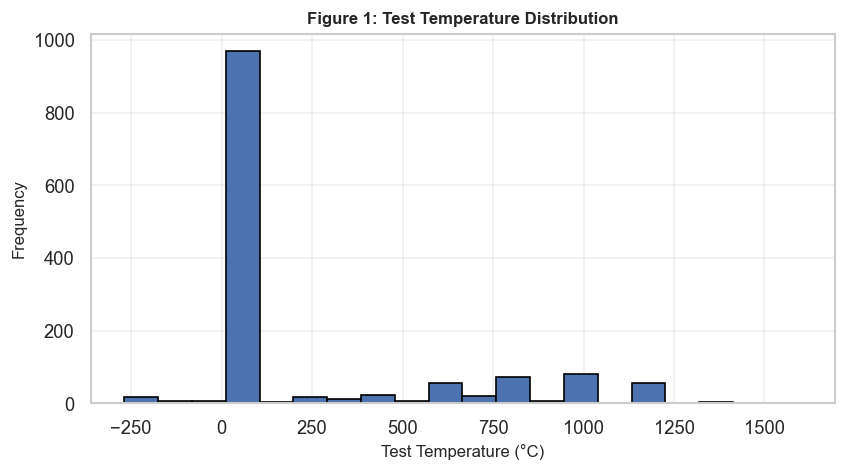

In [108]:
# Distribution of test temperatures

# Initialize figure
plt.figure(figsize=(8, 4))  

# Create temperature distribution histogram
plt.hist(mpea_raw[r"PROPERTY: Test temperature ($^\circ$C)"].dropna(), 
         bins=20, 
         edgecolor="black")

# Set labels
plt.xlabel("Test Temperature (°C)", fontsize=10)
plt.ylabel("Frequency", fontsize=10)
plt.title("Figure 1: Test Temperature Distribution", 
          weight="bold", 
          fontsize=10)

# Add grid
plt.grid(True, alpha=0.3)

# Save and display
plt.savefig("../analysis/figures/Fig01_test_temperatures.png", 
            dpi=300)
plt.show()

In [109]:
# Describe numeric fields
mpea_raw.describe()

,IDENTIFIER: Reference ID,PROPERTY: grain size ($\mu$m),PROPERTY: Exp. Density (g/cm$^3$),PROPERTY: Calculated Density (g/cm$^3$),PROPERTY: HV,PROPERTY: Test temperature ($^\circ$C),PROPERTY: YS (MPa),PROPERTY: UTS (MPa),PROPERTY: Elongation (%),PROPERTY: Elongation plastic (%),PROPERTY: Exp. Young modulus (GPa),PROPERTY: Calculated Young modulus (GPa),PROPERTY: O content (wppm),PROPERTY: N content (wppm),PROPERTY: C content (wppm),REFERENCE: year
count,1545.000000,237.000000,112.000000,1545.000000,530.000000,1364.000000,1067.000000,539.000000,619.000000,149.000000,145.000000,729.000000,57.000000,45.0,4.000000,1545.000000
mean,134.286084,90.222121,7.639518,7.962071,478.256792,227.960264,889.961471,1180.121243,30.216688,20.272349,124.972414,166.411523,764.000000,5.0,19911.750000,2016.209061
std,80.288645,182.997396,2.484075,1.760284,212.896712,379.131987,570.135437,720.870146,22.010637,25.725757,56.943524,48.864223,2084.998458,0.0,16142.818184,3.725479
min,1.000000,0.018200,1.460000,1.400000,94.700000,-268.800000,24.000000,80.000000,0.000000,0.000000,16.600000,72.000000,80.000000,5.0,1900.000000,2004.000000
25%,62.000000,3.000000,6.505000,6.900000,319.500000,25.000000,408.000000,674.625000,10.700000,6.000000,83.500000,110.000000,90.000000,5.0,8775.250000,2015.000000
50%,134.000000,20.000000,7.781500,7.800000,479.150000,25.000000,822.000000,1004.000000,27.900000,12.000000,99.200000,175.000000,100.000000,5.0,20683.500000,2018.000000
75%,210.000000,92.000000,8.680000,8.500000,624.750000,300.000000,1260.000000,1456.000000,50.000000,25.000000,182.000000,210.000000,200.000000,5.0,31820.000000,2019.000000
max,265.000000,2000.000000,13.600000,13.700000,1183.000000,1600.000000,3416.000000,4023.600000,105.000000,189.200000,240.000000,298.000000,7946.000000,5.0,36380.000000,2019.000000


### 1.3. Column Selection and Initial Cleaning

#### 1.3.1. Selecting Relevant Columns

To prepare the dataset for analysis, a careful selection of columns will be performed based on their relevance to the project’s objectives.


- **Reference ID** will be retained to ensure traceability. The other reference information (`doi`, `year`, `title`) can be retrieved from it if needed and will be excluded from the working dataset.
- **`PROPERTY: BCC/FCC/other`** will be discarded because its information is already fully captured, in greater detail, by **`PROPERTY: Microstructure`**.
- **Processing method**, **Grain size**, and **Density** will be kept, as these features may show relationships with yield strength and offer physical insights into alloy behavior.
- **Hardness (HV)** will not be the focus of this study. Although it is a valuable property, a similar workflow could be applied to it in the future.
- **Type of test** will initially be used to filter the dataset, retaining only compression tests. After subsetting, this column will no longer be needed and will be removed.
- **Test temperature** will also be used for subsetting, keeping only measurements performed at room temperature. After subsetting, this column will also be discarded.
- **Yield Strength (YS)** will be retained as the primary mechanical property of interest, representing the material’s transition from elastic to plastic deformation.
- **Ultimate Tensile Strength (UTS)** will be excluded to maintain focus on elastic regime properties rather than post-yield behavior.
- **Elongation (%), Elongation plastic (%), Experimental Young’s modulus,** and **Calculated Young’s modulus** will be excluded to narrow the scope of the analysis.  
- **O content, N content,** and **C content** contain mostly missing values and will also be discarded.

The project will center on studying **Yield Strength** and exploring how microstructure and processing methods may relate to superior mechanical performance.  
With that in mind, let's **select the columns** relevant to the project’s objectives:

In [110]:
# Define the list of columns to preserve
columns_to_keep = [
    "IDENTIFIER: Reference ID",
    "FORMULA",
    "PROPERTY: Microstructure",
    "PROPERTY: Processing method",
    r"PROPERTY: grain size ($\mu$m)",
    "PROPERTY: Exp. Density (g/cm$^3$)",
    "PROPERTY: Calculated Density (g/cm$^3$)",
    "PROPERTY: Type of test",
    r"PROPERTY: Test temperature ($^\circ$C)",
    "PROPERTY: YS (MPa)"
]

# Create a new DataFrame with the selected columns
mpea_selected = mpea_raw[columns_to_keep].copy()

#### 1.3.2. Data Subsetting: Room Temperature and Compression Tests  

This study focuses on **compressive yield strength** due to its prevalence in the dataset (792 entries vs. 358 for tensile tests). While tensile behavior remains an exciting avenue for future work, the mechanical differences between tensile and compressive deformation necessitate separating the datasets to ensure analytical rigor. The same methodology could later be adapted to explore tensile properties.  

For consistency, only tests performed at **room temperature** (25 °C) will be analyzed. Investigating different temperatures could certainly offer valuable insights, but would require a different approach. Let’s first confirm that room-temperature compression tests dominate the dataset, as suggested in the initial exploration:  

In [111]:
# Display the most common test temperatures
mpea_selected[r"PROPERTY: Test temperature ($^\circ$C)"].value_counts(dropna=False).sort_values(ascending=False)

PROPERTY: Test temperature ($^\circ$C)
25.0      911
NaN       181
1000.0     81
800.0      68
1200.0     55
         ... 
720.0       1
740.0       1
760.0       1
780.0       1
840.0       1
Name: count, Length: 65, dtype: int64

As expected, the majority of tests were conducted at **25.0 °C**. For our purposes, the dataset will be restricted to materials tested at this temperature:

In [112]:
# Filter dataset to keep only tests conducted at 25.0°C
mpea_selected = mpea_selected[mpea_selected[r"PROPERTY: Test temperature ($^\circ$C)"] == 25.0].copy()

Now, we'll keep only **compression tests** (where `Type of test = "C"`):

In [113]:
# Filter dataset to keep only compression tests
mpea_selected = mpea_selected[mpea_selected["PROPERTY: Type of test"] == "C"].copy()

After subsetting the dataset to room-temperature compression tests, the columns `PROPERTY: Test temperature (°C)` and `PROPERTY: Type of test` can be removed:

In [114]:
# Drop filtering columns
columns_to_drop = [
    r"PROPERTY: Test temperature ($^\circ$C)",
    "PROPERTY: Type of test"
]
mpea_selected = mpea_selected.drop(columns=columns_to_drop)

### 1.4. Missing Data Treatment

#### 1.4.1. Missing Values

The next step is to check for missing values across variables. Let's calculate the **percentage of missing values** in each column to identify fields with incomplete data:

In [115]:
# Percentage of missing values per column
(mpea_selected.isnull().mean() * 100).round(1)

IDENTIFIER: Reference ID                    0.0
FORMULA                                     0.0
PROPERTY: Microstructure                    5.4
PROPERTY: Processing method                 4.3
PROPERTY: grain size ($\mu$m)              86.5
PROPERTY: Exp. Density (g/cm$^3$)          94.1
PROPERTY: Calculated Density (g/cm$^3$)     0.0
PROPERTY: YS (MPa)                          9.9
dtype: float64

Now let's create a **missing values matrix** to visualize the distribution of missing data:

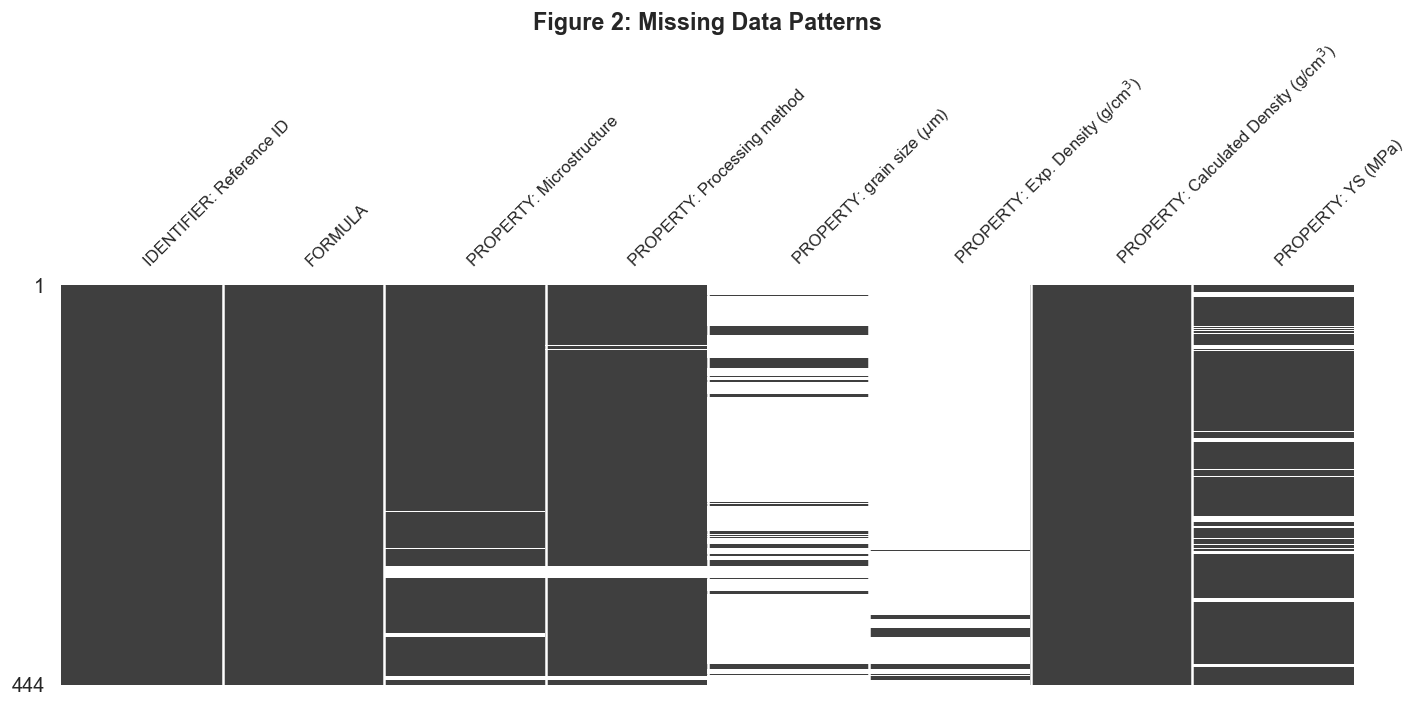

In [116]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Generate missingno matrix
msno.matrix(
    mpea_selected,
    sparkline=False,
    fontsize=10,
    ax=ax
)

# Grid visibility
ax.grid(visible=False)

# Add title
ax.set_title("Figure 2: Missing Data Patterns", fontsize=14, weight="bold")

# Save and display
plt.tight_layout()
plt.savefig("../analysis/figures/Fig02_missing_data.png", 
            dpi=300, 
            bbox_inches="tight")
plt.show()

After reviewing the missing values distribution, decisions about data cleaning can be made:

- **PROPERTY: Exp. Density (g/cm³)** and **PROPERTY: grain size (μm)** will be **dropped** because they have **over 85% missing values**.
- Since **Microstructure**, **Processing Method**, and **Yield Strength** are essential to the analyses, any rows lacking values in these columns will be **excluded**.

In [117]:
# Drop columns with excessive missing values
cols_to_drop = [
    "PROPERTY: Exp. Density (g/cm$^3$)",
    r"PROPERTY: grain size ($\mu$m)"
]

mpea_selected = mpea_selected.drop(columns=cols_to_drop)

# Drop rows with missing values
key_fields = [
    "PROPERTY: Microstructure",
    "PROPERTY: Processing method",
    "PROPERTY: YS (MPa)"
]
mpea_selected = mpea_selected.dropna(subset=key_fields).reset_index(drop=True)

# Quick check after cleaning
print(f"Shape: {mpea_selected.shape}")
print((mpea_selected.isnull().mean() * 100).round(2))

Shape: (376, 6)
IDENTIFIER: Reference ID                   0.0
FORMULA                                    0.0
PROPERTY: Microstructure                   0.0
PROPERTY: Processing method                0.0
PROPERTY: Calculated Density (g/cm$^3$)    0.0
PROPERTY: YS (MPa)                         0.0
dtype: float64


#### 1.4.2. Reliability Check: Calculated vs. Measured Density

Although the **experimentally reported densities were dropped** due to extensive **missing data**, it is still worthwhile to assess how well they align with the calculated densities in the subset where both are available.
This comparison provides a notion of the typical deviation between experimental and calculated values in MPEAs, helping us **evaluate the reliability of using calculated densities** in subsequent analyses.

In [118]:
# Select entries where both experimental and calculated densities are available
density_compare = mpea_raw[
    mpea_raw["PROPERTY: Exp. Density (g/cm$^3$)"].notna() &
    mpea_raw["PROPERTY: Calculated Density (g/cm$^3$)"].notna()
].copy()

# Compute the relative difference as a percentage
density_compare["Relative Difference (%)"] = (
    (density_compare["PROPERTY: Exp. Density (g/cm$^3$)"] - density_compare["PROPERTY: Calculated Density (g/cm$^3$)"]).abs()
    / density_compare["PROPERTY: Calculated Density (g/cm$^3$)"]) * 100

# Assess how often the calculated value deviates more than 10%
num_above_10 = (density_compare["Relative Difference (%)"] > 10).sum()
total_entries = len(density_compare)
percentage_above_10 = (num_above_10 / total_entries) * 100

print(f"Entries with >10% density difference: {num_above_10} out of {total_entries} ({percentage_above_10:.2f}%)")

Entries with >10% density difference: 8 out of 112 (7.14%)


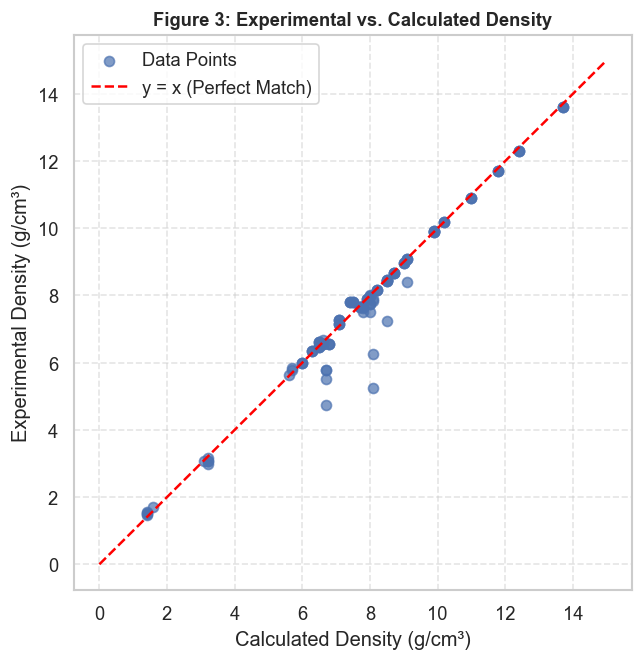

In [119]:
# Create scatter plot comparing calculated vs experimental density
plt.figure(figsize=(6, 6))
plt.scatter(
    density_compare["PROPERTY: Calculated Density (g/cm$^3$)"],
    density_compare["PROPERTY: Exp. Density (g/cm$^3$)"],
    alpha=0.7,
    label="Data Points"
)

# Add y = x reference line (perfect match)
plt.plot([0, 15], [0, 15], color="red", linestyle="--", label="y = x (Perfect Match)")

# Axis labels and title
plt.xlabel("Calculated Density (g/cm³)")
plt.ylabel("Experimental Density (g/cm³)")
plt.title("Figure 3: Experimental vs. Calculated Density", weight="bold")

# Add grid and legend
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Save and display
plt.savefig("../analysis/figures/Fig03_density.png", dpi=300)
plt.show()

Although the experimental density values were dropped due to insufficient coverage, this comparison shows that **calculated densities generally align well with their experimental counterparts**. In the 112 cases where both values are available, only 8 entries (approximately 7%) exhibit a relative difference greater than 10%. This suggests that the calculated density can be considered reasonably reliable for further analysis. Nonetheless, caution is advised, as deviations beyond 10% do occur in 8 out of 112 cases.

### 1.5. Column Renaming and Type Conversion

With only the relevant fields remaining, the next step is to **rename the columns for clarity**. 

Prefixes like `PROPERTY:` will be removed, abbreviations will be expanded, and names will be made more readable to support a clean and interpretable analysis workflow.

In [120]:
# Rename columns for clarity
rename_mapping = {
    "IDENTIFIER: Reference ID": "Reference ID",
    "FORMULA": "Formula",
    "PROPERTY: Microstructure": "Microstructure",
    "PROPERTY: Processing method": "Processing Method",
    "PROPERTY: Calculated Density (g/cm$^3$)": "Calculated Density (g/cm³)",
    "PROPERTY: YS (MPa)": "Yield Strength (MPa)",
}

mpea_selected = mpea_selected.rename(columns=rename_mapping)

Now let's check the **data types** of each variable:

In [121]:
# Check data types
print(mpea_selected.dtypes)

Reference ID                    int64
Formula                        object
Microstructure                 object
Processing Method              object
Calculated Density (g/cm³)    float64
Yield Strength (MPa)          float64
dtype: object


Since both **Microstructure** and **Processing Method** have few distinct categories, they will be converted to the `category` data type:

In [122]:
# Convert columns to 'category' dtype
cols_to_category = ["Microstructure", "Processing Method"]
mpea_selected[cols_to_category] = mpea_selected[cols_to_category].astype("category")

# Reorder 'Processing Method' categories
processing_order = ["ANNEAL", "CAST", "POWDER", "WROUGHT", "OTHER"]
mpea_selected["Processing Method"] = mpea_selected["Processing Method"].cat.reorder_categories(
    processing_order,
    ordered=True
)

# Confirm updated data types
print(mpea_selected.dtypes)

Reference ID                     int64
Formula                         object
Microstructure                category
Processing Method             category
Calculated Density (g/cm³)     float64
Yield Strength (MPa)           float64
dtype: object


In [123]:
# Check updated dataset
mpea_selected.head(3)

,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa)
0,27,Al0.25 Co1 Fe1 Ni1,FCC,CAST,7.9,158.0
1,27,Al0.5 Co1 Fe1 Ni1,FCC+BCC,CAST,7.4,346.0
2,27,Al0.75 Co1 Fe1 Ni1,FCC+BCC,CAST,7.0,794.0


The column names and data types have been successfully adjusted, and the dataset is now ready for the next stage: documenting a data dictionary.

### 1.6 Data Dictionary 

Before diving deeper, let’s build a **data dictionary** to keep our dataset organized. It will help track the meaning and purpose of each column during the next steps.

Below is a summary of the cleaned dataset, with variable names, types, and short descriptions:

| Column                     | Data Type  | Description                                                                 |
|---------------------------|------------|-----------------------------------------------------------------------------|
| Reference ID              | int64      | Internal identifier used for traceability                                  |
| Formula                   | object     | Chemical formula of the alloy                                              |
| Microstructure            | category   | Observed microstructure phase (e.g., FCC, BCC, FCC+BCC)                    |
| Processing Method         | category   | Technique used to prepare the alloy (e.g., CAST, WROUGHT)                              |
| Calculated Density (g/cm³)| float64    | Density calculated using the rule of mixtures (ROM)                        |
| Yield Strength (MPa)      | float64    | Compressive yield strength (stress at which material undergoes plastic deformation under compression)


### 1.7. Data Validation
Although the study authors performed careful validation of the dataset during its compilation, an **additional verification** step will be carried out to ensure consistency before beginning the exploratory analysis. A quick check will be conducted on the dataset's structure and basic variable ranges to confirm there are no anomalies that could affect later stages of the project.

Let's ensure the dataset does not contain **duplicated rows**.

In [124]:
# Check for duplicated rows
print("Duplicated rows:", mpea_selected.duplicated().sum())

Duplicated rows: 1


A single duplicate was found. Let's take a look at it:

In [125]:
# Display the duplicated rows
duplicated_rows = mpea_selected[mpea_selected.duplicated()]
duplicated_rows

,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa)
59,35,Al1 Cu0.889 Fe0.667 Ni0.889 Ti1,FCC,CAST,5.9,980.0


We’ll now **remove the duplicate** to avoid redundancy:

In [126]:
# Remove the duplicated row
mpea_selected = mpea_selected.drop_duplicates().reset_index(drop=True)

Finally, we’ll confirm that no duplicated rows remain:

In [127]:
# Re-check for duplicates
print("Remaining duplicated rows:", mpea_selected.duplicated().sum())

# Quick check after cleaning
print(f"Shape: {mpea_selected.shape}")

Remaining duplicated rows: 0
Shape: (375, 6)


Now let's verify the values in each column:

In [128]:
# Check unique Microstructure values
print(sorted(mpea_selected["Microstructure"].unique()))

['B2', 'B2+BCC', 'B2+L12', 'B2+Laves+Sec.', 'B2+Sec.', 'BCC', 'BCC+B2', 'BCC+B2+FCC', 'BCC+B2+FCC+Sec.', 'BCC+B2+Laves', 'BCC+BCC', 'BCC+BCC+Sec.', 'BCC+FCC', 'BCC+HCP', 'BCC+Laves', 'BCC+Laves+Sec.', 'BCC+Sec.', 'FCC', 'FCC+BCC', 'FCC+BCC+B2', 'FCC+BCC+BCC', 'FCC+BCC+Sec.', 'FCC+FCC', 'FCC+HCP+Sec.', 'FCC+Laves', 'FCC+Sec.', 'Other']


In [129]:
# Check unique Processing Method values
print(mpea_selected["Processing Method"].unique())

['CAST', 'POWDER', 'ANNEAL', 'OTHER', 'WROUGHT']
Categories (5, object): ['ANNEAL' < 'CAST' < 'POWDER' < 'WROUGHT' < 'OTHER']


In [130]:
# Describe numeric variables
mpea_selected.describe()

,Reference ID,Calculated Density (g/cm³),Yield Strength (MPa)
count,375.000000,375.000000,375.000000
mean,105.533333,7.834133,1310.164053
std,77.496271,1.901831,569.015082
min,2.000000,2.900000,140.000000
25%,47.500000,6.700000,1000.500000
50%,86.000000,7.400000,1300.000000
75%,140.500000,8.450000,1616.500000
max,264.000000,13.700000,3416.000000


I'll briefly inspect the **extreme values** observed in the numerical variables to confirm their plausibility.

- The **calculated densities** range from 2.9 to 13.7 g/cm³, consistent with both light and heavy alloys in multicomponent systems.  
- The **maximum yield strength** (3416 MPa) is quite high and will be checked to confirm its validity, while the **lowest value** (140 MPa) appears to be low for a metal and will be verified to ensure it reflects a valid measurement.

Let's investigate these cases in more detail.

In [131]:
# Check the entry with the highest yield strength
max_ys_row = mpea_selected[mpea_selected["Yield Strength (MPa)"] == mpea_selected["Yield Strength (MPa)"].max()]
print("Alloy with maximum yield strength:")
display(max_ys_row)

Alloy with maximum yield strength:


,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa)
253,147,Cr1 Mo1 Nb1 Ta1 V1 W1,BCC+Laves+Sec.,POWDER,11.7,3416.0


In [132]:
# Check the entry with the lowest yield strength
min_ys_row = mpea_selected[mpea_selected["Yield Strength (MPa)"] == mpea_selected["Yield Strength (MPa)"].min()]
print("Alloy with lowest yield strength:")
display(min_ys_row)

Alloy with lowest yield strength:


,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa)
138,62,Cu1 Mn1 Ni1 Zn0.25,FCC,CAST,8.3,140.0


The article linked to **Reference ID 147**, retrieved using the DOI provided in the original dataset, reports the development of fine-grained alloys. The study confirms that the alloy achieved an exceptional **yield strength of 3416 MPa**, consistent with the value recorded in the dataset.

The article linked to **Reference ID 62** discusses high-entropy brasses and bronzes and confirms that **[CuMnNi]₈₀Zn₂₀** alloys exhibited a **yield strength** of just **140 MPa** alongside over 65% ductility. This confirms that the low value observed in the dataset is not an error.

Having validated the plausibility of extreme values and ensured overall consistency, we conclude the data validation stage with a final set of **375 alloys**.  
Let’s **save the cleaned dataset** for future use and proceed to the Exploratory Data Analysis.

In [133]:
# Rename the cleaned DataFrame
mpea_clean = mpea_selected.copy()

# Save cleaned dataset for future use
mpea_clean.to_csv("../data/processed/mpea_clean.csv", index=False)

---

## 2. Exploratory Data Analysis (EDA)

### 2.1. Yield Strength and Density Variation by Processing Method

Our exploratory analysis begins by examining how different processing methods affect material properties. **Figure 4** presents a stratified visualization combining **boxplots** (showing quartile distributions) with **jittered scatter points** (representing individual observations), revealing two key dimensions:  

1. **Yield Strength Variation**: The boxplot elements highlight median compressive yield strength (horizontal lines), interquartile ranges (boxes), and overall dispersion across processing methods.
   
2. **Density Relationship**: Points are color-mapped to density values, where higher-density materials correspond to darker colors.  

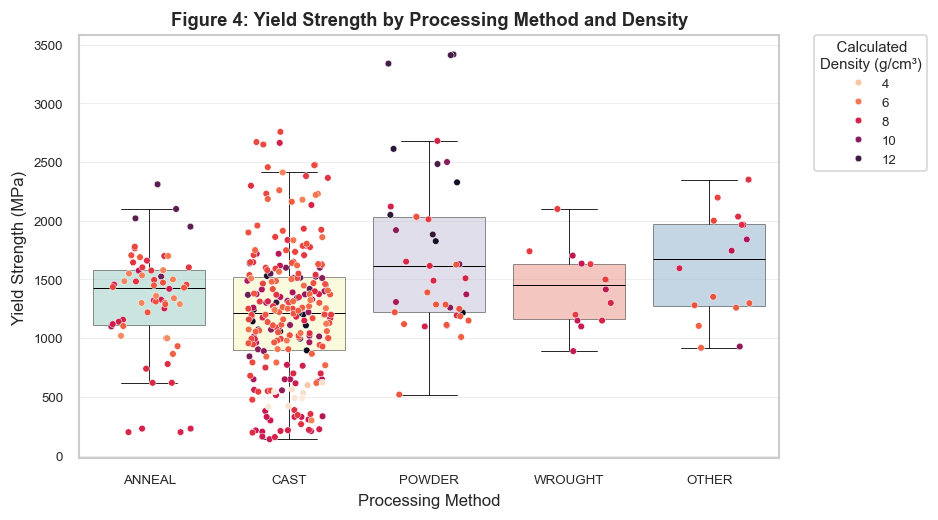

In [134]:
# Sort data by density to layer larger dots behind
sorted_data = mpea_clean.sort_values("Calculated Density (g/cm³)", ascending=False)

# Define box colors per method
box_colors = {
    "ANNEAL": "#8dd3c7",
    "CAST": "#ffffb3",
    "POWDER": "#bebada",
    "WROUGHT": "#fb8072",
    "OTHER": "#80b1d3"
}

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(8, 4.5))

# Create boxplot
sns.boxplot(
    x="Processing Method",
    y="Yield Strength (MPa)",
    hue="Processing Method",
    data=sorted_data,
    palette=box_colors,
    fliersize=0,
    linewidth=0.5,
    boxprops=dict(edgecolor="black", linewidth=0.5, alpha=0.5),
    whiskerprops=dict(linewidth=0.5, color="black"),
    capprops=dict(linewidth=0.5, color="black"),
    medianprops=dict(linewidth=0.6, color="black"),
)

# Overlay dots
scatter = sns.stripplot(
    x="Processing Method",
    y="Yield Strength (MPa)",
    data=sorted_data,
    hue="Calculated Density (g/cm³)",
    size=4,
    jitter=0.3,
    palette=sns.color_palette("rocket_r", as_cmap=True),
    edgecolor="w",
    linewidth=0.3
)

# Customize legend
scatter.legend(
    bbox_to_anchor=(1.05, 1),
    loc=2,
    borderaxespad=0.,
    title="    Calculated\nDensity (g/cm³)",
    frameon=True,
    fontsize=8,
    title_fontsize=9
)

# Set axis and title
plt.title("Figure 4: Yield Strength by Processing Method and Density", fontsize=11, weight="bold")
plt.xlabel("Processing Method", fontsize=10)
plt.ylabel("Yield Strength (MPa)", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# Add y-grid
ax = plt.gca()
ax.xaxis.grid(False)
ax.yaxis.grid(True, linestyle="-", linewidth=0.4, alpha=0.5)

# Save and display
plt.tight_layout()
plt.savefig("../analysis/figures/Fig04_box_plots.png", 
            dpi=300)
plt.show()

#### **Key Insights:**  

1. **POWDER Processed Materials**  
   - Achieve the **highest median compressive strength** among all methods (≈1,600 MPa)  
   - Include **three exceptional outliers** (≈3,400 MPa at ≈12 g/cm³ calculated density), suggesting potential for specialized high-strength applications
<br><br>
2. **CAST Alloys (Most Prevalent in Dataset)**  
   - Exhibit the **lowest median strength** (≈1,250 MPa) but wide variation (≈150–2,750 MPa)
   - Upper-range cast samples demonstrate notable strength at moderate densities
<br><br>
3. **ANNEALED Specimens**  
   - Three high-density samples (≈12 g/cm³) exceed 2,000 MPa, showing potential for non-weight-critical applications
<br><br>
4. **WROUGHT and OTHER Methods**  
   - Exhibit lower variation in both density and strength values
   - Include five alloys with ≈8 g/cm³ density exceeding 2,000 MPa strength, representing well-balanced candidates for general engineering applications

### 2.2. Yield Strength and Density Distribution by Microstructure

In this section, we explore how **microstructural variations** relate to the **yield strength** and **density** of the alloys.

**Figure 5** provides an excellent general overview, where **each point represents an alloy**, colored and marked by its microstructure type. **Contour lines** corresponding to specific **strength-to-weight ratios** are also included, highlighting regions of high mechanical efficiency.  

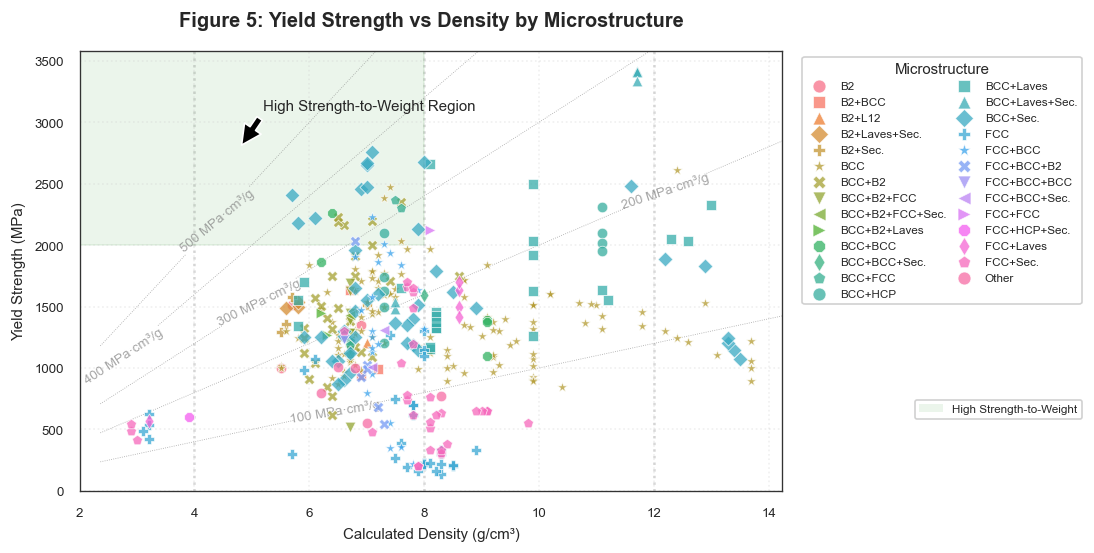

In [135]:
# Set plot style
sns.set_style("whitegrid", {"grid.linestyle": ":", "grid.alpha": 0.4})
plt.rcParams["figure.dpi"] = 120
plt.rcParams["savefig.dpi"] = 300

# Create figure
fig, ax = plt.subplots(figsize=(9, 4.5), constrained_layout=True)

# Set visual parameters
palette = sns.color_palette("husl", n_colors=len(mpea_clean["Microstructure"].unique()))
markers = ["o", "s", "^", "D", "P", "*", "X", "v", "<", ">", "8", "d", "p"]

# Create marker and color mapping
microstructures = sorted(mpea_clean["Microstructure"].unique())
marker_map = {micro: markers[i % len(markers)] for i, micro in enumerate(microstructures)}
color_map = {micro: palette[i] for i, micro in enumerate(microstructures)}

# Create scatter plot
for i, micro in enumerate(microstructures):
    subset = mpea_clean[mpea_clean["Microstructure"] == micro]
    ax.scatter(
        subset["Calculated Density (g/cm³)"],
        subset["Yield Strength (MPa)"],
        label=micro,
        marker=marker_map[micro],
        color=color_map[micro],
        s=40,
        alpha=0.75,
        edgecolor="w",
        linewidth=0.5,
        zorder=5
    )

# Strength-to-weight contour lines
# Create grid for contour calculations
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
density_range = np.linspace(x_min, x_max, 100)
strength_range = np.linspace(y_min, y_max, 100)
D, S = np.meshgrid(density_range, strength_range)
Z = S / D  # Specific Strength (MPa·cm³/g)

# Plot contour lines
contour_levels = [100, 200, 300, 400, 500]
CS = ax.contour(
    D, S, Z, levels=contour_levels,
    colors="gray", linestyles=":", linewidths=0.5, alpha=0.7,
    zorder=1
)
ax.clabel(CS, inline=True, fontsize=8, fmt="%.0f MPa·cm³/g")

# Vertical density references
for density in [4, 8, 12]:
    ax.axvline(density, color="gray", linestyle=":", alpha=0.3, zorder=0)

# Highlight high strength-to-weight region
ax.set_xlim(left=2)
ax.set_ylim(bottom=0)
ax.fill_betweenx(
    [2000, ax.get_ylim()[1]],
    0, 8,
    color="green", alpha=0.08, zorder=0,
    label="High Strength-to-Weight"
)

# Plot Customization
ax.set_xlabel("Calculated Density (g/cm³)", fontsize=9, labelpad=5)
ax.set_ylabel("Yield Strength (MPa)", fontsize=9, labelpad=5)
ax.set_title("Figure 5: Yield Strength vs Density by Microstructure", 
             fontsize=12, pad=15, weight="bold")
ax.tick_params(axis="both", labelsize=8)

# Legend
handles, labels = ax.get_legend_handles_labels()
# Separate scatter and fill legends
scatter_legend = ax.legend(
    handles[:len(microstructures)], labels[:len(microstructures)],
    title="Microstructure",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0.5,
    columnspacing=0.5,
    frameon=True,
    framealpha=0.9,
    fontsize=7,
    title_fontsize=9,
    ncol=2
)
ax.add_artist(scatter_legend)

# Performance zone legend
performance_handles = [plt.Rectangle((0,0), 1, 1, fc="green", alpha=0.08, ec="none")]
ax.legend(
    performance_handles, ["High Strength-to-Weight"],
    bbox_to_anchor=(1.18, 0.15),
    loc="lower left",
    frameon=True,
    framealpha=0.9,
    fontsize=7
)

# Adjust legend marker sizes
for handle in scatter_legend.legend_handles:
    handle.set_sizes([60])

# Grid and Borders
ax.grid(True, alpha=0.3)
for spine in ax.spines.values():
    spine.set_edgecolor("#333333")
    spine.set_linewidth(0.8)

# Annotation
ax.annotate("High Strength-to-Weight Region",
            xy=(4.8, 2800), xytext=(5.2, 3100),
            arrowprops=dict(facecolor="black", shrink=0.05),
            fontsize=9, zorder=9)

# Save and display
plt.savefig("../analysis/figures/Fig05_scatter_plot.png", 
            dpi=300)
plt.show()

While this visualization effectively captures broad patterns across different microstructures, some regions exhibit overlapping data points that are difficult to distinguish.  
To enhance readability, **Figure 6** separates the data into dedicated **subplots for each microstructure type**, incorporating processing methods for a more informative breakdown.

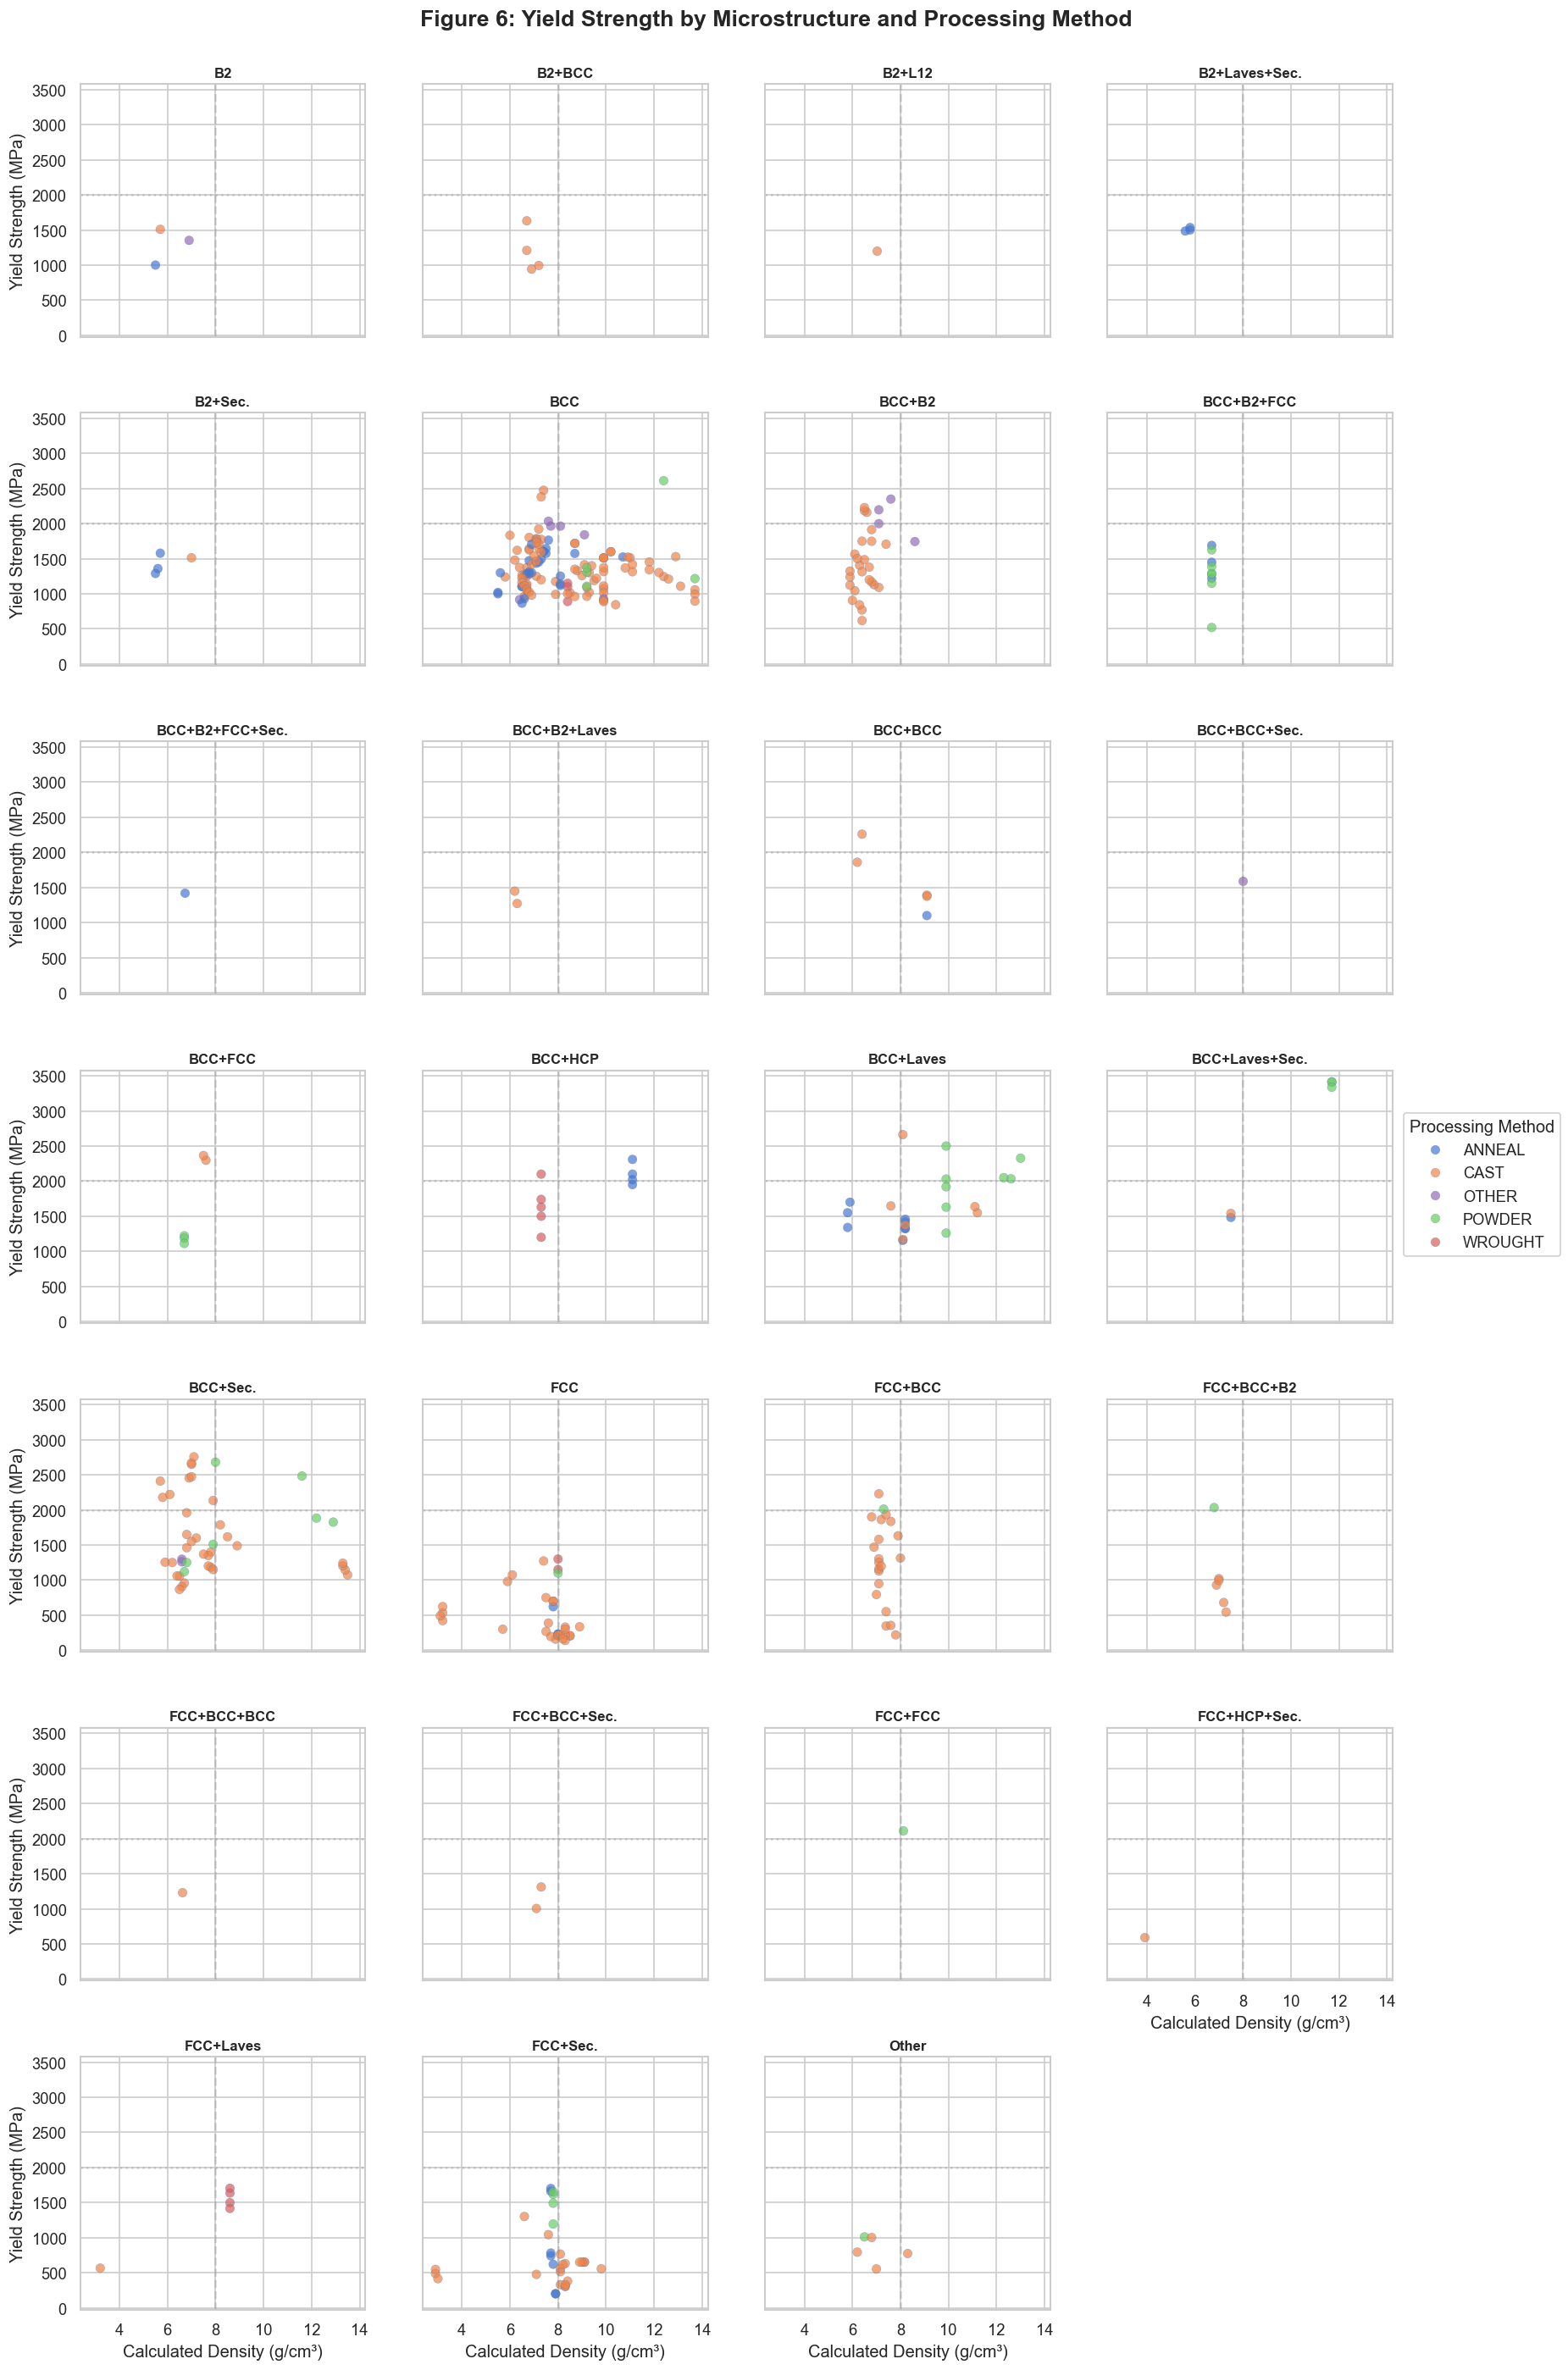

In [136]:
# Configure style
sns.set_style("whitegrid", {"grid.alpha": 0.1})
plt.rcParams.update({"font.size": 10, "axes.titlesize": 11})

# Initialize grid
g = sns.FacetGrid(
    mpea_clean,
    col="Microstructure",
    col_wrap=4,
    height=3.5,
    aspect=1,
    sharey=True,
    sharex=True,
    despine=False
)

# Map the scatterplot
scatter = g.map_dataframe(
    sns.scatterplot,
    x="Calculated Density (g/cm³)",
    y="Yield Strength (MPa)",
    hue="Processing Method",
    palette="muted",
    alpha=0.7,
    s=40,
    edgecolor="b",
    linewidth=0.2
)

# Add reference lines
def add_ref_lines(data, **kwargs):
    plt.axhline(2000, color="gray", ls=":", alpha=0.3)
    plt.axvline(8, color="gray", ls="--", alpha=0.3)
    
g.map_dataframe(add_ref_lines)

# Set titles and legend
g.set_titles(
    template="{col_name}", 
    size=10, 
    pad=5, 
    fontweight="semibold"
)
g.fig.suptitle(
    "Figure 6: Yield Strength by Microstructure and Processing Method", 
    y=0.95,
    fontsize=16,
    fontweight="bold"
)
g.add_legend(
    title="Processing Method",
    label_order=sorted(mpea_clean["Processing Method"].unique()),
    frameon=True,
    framealpha=0.9
)

# Adjust layout
plt.subplots_adjust(top=0.92, hspace=0.3, wspace=0.2)

# Save and display
plt.savefig("../analysis/figures/Fig06_microstructures.png", 
            dpi=300)
plt.show()

#### Key Insights:

- The **upper region** of the plots highlights materials with **high compressive yield strength**.  
- The **top-left corner** is particularly interesting, representing alloys that combine **high strength** with **lower density**.  
- **BCC+Laves+Sec.** alloys obtained through **powder processing** show the **highest yield strength values** (~3400 MPa), with densities around **12 g/cm³** (see Figure 6). Despite their high density, their strength levels are exceptional.  
- About **10 BCC+Sec. alloys** are found above **2,000 MPa** yield strength and below **8 g/cm³** density, offering an attractive combination for **strength-to-weight** applications.  
- **BCC+B2** (5 alloys) and **BCC** (3 alloys) are the next most frequent microstructures in the high strength-to-weight region, confirming the importance of **BCC-based systems** for achieving superior performance.

### 2.3. Alloys with Superior Mechanical Performance

#### 2.3.1. High-Strength Alloys: Processing Methods and Microstructures

Let's take a closer look at the materials that stand out in terms of mechanical performance. Now we will focus on the top 10% of alloys according to two key metrics:
- **Yield Strength**, which in this project refers specifically to compressive yield strength, based on our decision to focus on compression data  
- **Strength-to-Weight Ratio,** estimated using calculated density values

For each group, let's analyze the distribution of **processing methods** and **microstructure types**. This helps us identify which characteristics are most commonly associated with high-performing alloys.

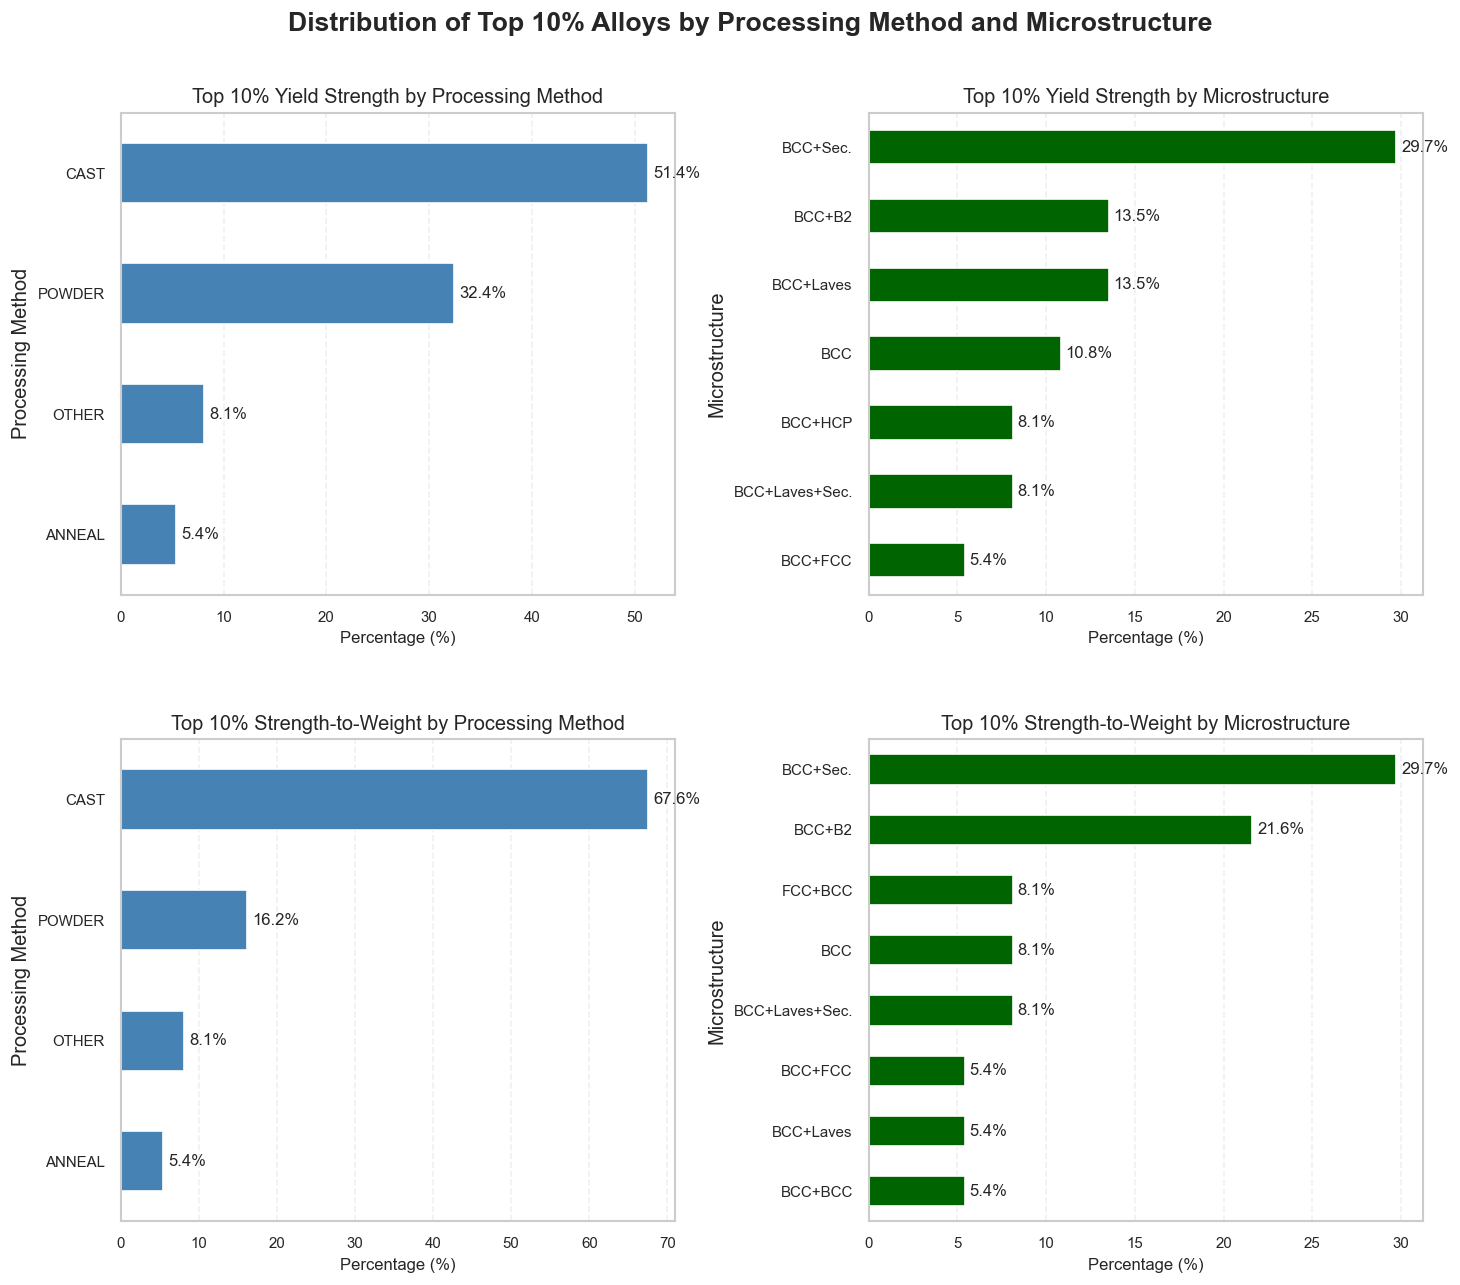

In [137]:
# Compute strength-to-weight ratio
mpea_clean["Strength-to-Weight Ratio (MPa·cm³/g)"] = (
    mpea_clean["Yield Strength (MPa)"] / mpea_clean["Calculated Density (g/cm³)"]
)

# Select top 10% performers
top10_ys = mpea_clean.nlargest(int(len(mpea_clean) * 0.10), "Yield Strength (MPa)")
top10_sw = mpea_clean.nlargest(int(len(mpea_clean) * 0.10), "Strength-to-Weight Ratio (MPa·cm³/g)")

# Functions for category distribution
def category_distribution(data, column):
    return data[column].value_counts(normalize=True) * 100

def clean_distribution(dist, threshold=5):
    return dist[dist > threshold].sort_values(ascending=True)

# Cleaned distributions
distributions = [
    ("Top 10% Yield Strength by Processing Method", clean_distribution(category_distribution(top10_ys, "Processing Method")), "steelblue"),
    ("Top 10% Yield Strength by Microstructure", clean_distribution(category_distribution(top10_ys, "Microstructure")), "darkgreen"),
    ("Top 10% Strength-to-Weight by Processing Method", clean_distribution(category_distribution(top10_sw, "Processing Method")), "steelblue"),
    ("Top 10% Strength-to-Weight by Microstructure", clean_distribution(category_distribution(top10_sw, "Microstructure")), "darkgreen")
]

# Set up plot
fig, axs = plt.subplots(2, 2, figsize=(14, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.35)
fig.suptitle("Distribution of Top 10% Alloys by Processing Method and Microstructure", fontsize=16, fontweight="bold", y=0.95)

# Plot each chart in a loop
for ax, (title, data, color) in zip(axs.ravel(), distributions):
    data.plot.barh(ax=ax, color=color)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Percentage (%)", fontsize=10)
    ax.tick_params(axis="both", labelsize=9)
    ax.grid(axis="x", linestyle="--", alpha=0.3)
    ax.grid(axis="y", visible=False)
    ax.bar_label(ax.containers[0], fmt="%.1f%%", padding=3)

# Save and show
plt.savefig("../analysis/figures/Fig07_top_10_percent.png", dpi=300, bbox_inches="tight")
plt.show()

#### Key Insights from Top 10% High-Performing Alloys

- **Casting** is the most common **processing method** among both:
  - Alloys with the highest yield strength
  - Alloys with the highest strength-to-weight ratio  
  It is followed by **powder metallurgy** in both cases.
<br><br>
- In terms of **microstructure**:
  - The top **yield strength** alloys are predominantly of types **BCC+Sec.**, **BCC+B2**, **BCC+Laves**, and **BCC**.
  - The top **strength-to-weight** alloys are most frequently **BCC+Sec.** and **BCC+B2**, followed by **FCC+BCC**, **BCC**, and **BCC+Laves+Sec.**


#### 2.3.2. Top 15 Alloys

To finish this Exploratory Data Analysis, we present the **top 15 alloys** ranked by **Yield Strength** and **Strength-to-Weight Ratio**. The latter is calculated using estimated density values and serves as an approximation of specific strength.

As previously noted, these rankings are based on the subset of alloys tested under compressive loading at room temperature (25 °C), which is the focus of this study.

In [138]:
# Top 15 by Yield Strength
top15_yield_strength = mpea_clean.sort_values("Yield Strength (MPa)", ascending=False).head(15)
display(top15_yield_strength.style.set_caption("Top 15 Alloys by Yield Strength"))

# Save top 15 alloys to CSV for future reference
top15_yield_strength.to_csv("../data/processed/top_15_yield_strength.csv", index=False)

,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa),Strength-to-Weight Ratio (MPa·cm³/g)
253,147,Cr1 Mo1 Nb1 Ta1 V1 W1,BCC+Laves+Sec.,POWDER,11.700000,3416.000000,291.965812
254,147,Cr1 Mo1 Nb1 Ta1 V1 W1,BCC+Laves+Sec.,POWDER,11.700000,3410.000000,291.452991
255,147,Cr1 Mo1 Nb1 Ta1 V1 W1,BCC+Laves+Sec.,POWDER,11.700000,3338.000000,285.299145
23,7,Al1 Co1 Cr1 Fe1 Mo0.5 Ni1,BCC+Sec.,CAST,7.100000,2757.000000,388.309859
257,206,Cr0.286 Mo0.476 Nb1 Ta0.024 Ti0.31 V0.286,BCC+Sec.,POWDER,8.000000,2680.000000,335.000000
22,7,Al1 Co1 Cr1 Fe1 Mo0.4 Ni1,BCC+Sec.,CAST,7.000000,2670.000000,381.428571
279,233,Cr1 Fe1 Mo1 Nb1 V1,BCC+Laves,CAST,8.100000,2663.000000,328.765432
21,7,Al1 Co1 Cr1 Fe1 Mo0.3 Ni1,BCC+Sec.,CAST,7.000000,2649.000000,378.428571
206,94,Mo1 Nb1 Ta1 V1 W1,BCC,POWDER,12.400000,2612.000000,210.645161
290,244,Cr1 Mo1 Nb1 Ti1 W1,BCC+Laves,POWDER,9.900000,2500.000000,252.525253


In [139]:
# Top 15 by Strength-to-Weight Ratio
top15_strength_to_weight = mpea_clean.sort_values("Strength-to-Weight Ratio (MPa·cm³/g)", ascending=False).head(15)
display(top15_strength_to_weight.style.set_caption("Top 15 Alloys by Strength-to-Weight Ratio"))

# Save top 15 alloys to CSV for future reference
top15_strength_to_weight.to_csv("../data/processed/top15_strength_to_weight.csv", index=False)

,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa),Strength-to-Weight Ratio (MPa·cm³/g)
30,12,Al1 Co1 Cr1 Fe1 Ni1 Si1,BCC+Sec.,CAST,5.700000,2411.000000,422.982456
23,7,Al1 Co1 Cr1 Fe1 Mo0.5 Ni1,BCC+Sec.,CAST,7.100000,2757.000000,388.309859
22,7,Al1 Co1 Cr1 Fe1 Mo0.4 Ni1,BCC+Sec.,CAST,7.000000,2670.000000,381.428571
21,7,Al1 Co1 Cr1 Fe1 Mo0.3 Ni1,BCC+Sec.,CAST,7.000000,2649.000000,378.428571
34,12,Al1 Co1 Cr1 Fe1 Ni1 Si0.8,BCC+Sec.,CAST,5.800000,2179.000000,375.689655
41,14,Al0.667 Co0.667 Cr0.667 Fe0.667 Ni0.667 Ti1,BCC+Sec.,CAST,6.100000,2220.000000,363.934426
20,7,Al1 Co1 Cr1 Fe1 Mo0.2 Ni1,BCC+Sec.,CAST,6.900000,2456.000000,355.942029
27,8,Al1 Co1 Cr1 Fe1 Nb0.5 Ni1,BCC+Sec.,CAST,7.000000,2473.000000,353.285714
40,14,Al1 Co1 Cr1 Fe1 Ni1 Ti0.5,BCC+BCC,CAST,6.400000,2260.000000,353.125000
372,264,Al1 Cr1 Fe1 Mo0.5 Ni1 Ti0.5,BCC+B2,CAST,6.500000,2228.700000,342.876923


Notably, several variants of cast **Al–Co–Cr–Fe–Ni-based alloys** dominate the strength-to-weight ranking. In the next section, we will explore whether such patterns can be learned and generalized through machine learning models.

---

## 3. Modeling and Predictive Analysis

### 3.1. Integrating Composition Data

To provide a more robust foundation for machine learning tasks, we will now incorporate the **`compositions.csv`** file provided by the dataset authors on GitHub [(Citrine Informatics, MPEA Dataset GitHub)](https://github.com/CitrineInformatics/MPEA_dataset/tree/master). This file contains pre-parsed elemental fractions for each unique composition in the dataset.

Let's **load the file** and rename the identifier column in the composition table to match the `Formula` column in `mpea_clean`, then perform a left join to keep only the alloys we've already validated.

In [140]:
# Load file
compositions = pd.read_csv("../data/raw/compositions.csv")

# Rename column
compositions = compositions.rename(columns={"Alloy name": "Formula"})

# Merge into main dataset
mpea_modeling = pd.merge(mpea_clean, compositions, on="Formula", how="left")

# Display first rows
mpea_modeling.head(3)

,Reference ID,Formula,Microstructure,Processing Method,Calculated Density (g/cm³),Yield Strength (MPa),Strength-to-Weight Ratio (MPa·cm³/g),Ag,Al,B,...,Sc,Si,Sn,Ta,Ti,V,W,Y,Zn,Zr
0,27,Al0.25 Co1 Fe1 Ni1,FCC,CAST,7.9,158.0,20.000000,NaN,0.077,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,27,Al0.5 Co1 Fe1 Ni1,FCC+BCC,CAST,7.4,346.0,46.756757,NaN,0.143,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,Al0.75 Co1 Fe1 Ni1,FCC+BCC,CAST,7.0,794.0,113.428571,NaN,0.200,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.1.1. Fill missing values in element columns

NaNs in the composition columns simply indicate that the element is not present in that alloy. Let's replace them with `0.0`:

In [141]:
# Fill NaNs in composition columns with 0 (element absent)
composition_cols = compositions.columns.drop("Formula")
mpea_modeling[composition_cols] = mpea_modeling[composition_cols].fillna(0.0)

# Confirm that all missing values have been handled
print(f"Shape: {mpea_modeling.shape}")
print("Total missing values:", mpea_modeling.isnull().sum().sum())

# Save the modeling-ready dataset for future use
mpea_modeling.to_csv("../data/processed/mpea_modeling.csv", index=False)

Shape: (375, 37)
Total missing values: 0


### 3.2. Modeling Strategy

#### **Objective**
Develop **predictive models** for compressive **yield strength** using:
- **Chemical composition** (elemental fractions).  
- **Microstructure** (e.g., `"BCC+Laves+Sec."`, `"FCC"`).  
- **Processing Method** (e.g., `"POWDER"`, `"CAST"`).

**Excluded Features:**
- Calculated density (to prevent data leakage, as it's derived from composition)
- Formula and Reference ID (identifiers, not predictive features)
<br><br>
<h4 align="center">Model Selection Rationale</h4>

| Model | Type | Purpose | Expected Advantages |  
|-------|------|---------|---------------------|  
| **Ridge Regression** | Linear | Baseline | Simple, interpretable coefficients. |  
| **KNN Regressor** | Non-parametric | Capture local patterns | Flexible to complex relationships. |  
| **XGBoost** | Ensemble | Optimized performance | Feature importance + predictive power. |  


### 3.3. Data Preparation

In [142]:
# Load dataset
mpea_modeling = pd.read_csv("../data/processed/mpea_modeling.csv")

# Define features and target
X = mpea_modeling.drop(columns=[
    "Yield Strength (MPa)", 
    "Formula", 
    "Reference ID", 
    "Calculated Density (g/cm³)",
    "Strength-to-Weight Ratio (MPa·cm³/g)"
])
y = mpea_modeling["Yield Strength (MPa)"]

# Identify feature types
categorical_features = ["Microstructure", "Processing Method"]
numerical_features = X.select_dtypes(include=["number"]).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15
)

# Function to handle unknown categories in test set
def handle_unknown_categories(X_train, X_test, col):
    train_cats = set(X_train[col])
    return X_test[col].apply(lambda x: x if x in train_cats else "Other")

# Replace unseen categories in test set
for col in categorical_features:
    X_test[col] = handle_unknown_categories(X_train, X_test, col)

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
])

### 3.4. Baseline: Ridge Regression
We begin with **Ridge regression** as our **benchmark**, using L2 regularization to handle potential multicollinearity in features.

In [143]:
# Ridge pipeline
ridge_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 20)))
])

# Train and evaluate
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
print(f"R²: {r2_ridge:.3f}, RMSE: {rmse_ridge:.1f} MPa")

R²: 0.485, RMSE: 454.4 MPa


The Ridge regression model explains **~48%** of variance, establishing our minimum acceptable performance threshold.

### 3.5. KNN Regression
We next implement **KNN** to capture local similarity patterns that the linear model misses.

In [144]:
# KNN pipeline
knn_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor())
])

# Hyperparameter grid
param_grid_knn = {
    "knn__n_neighbors": range(3, 20, 2),
    "knn__weights": ["uniform", "distance"]
}

# Grid search
cv = KFold(n_splits=5, shuffle=True, random_state=15)
knn_search = GridSearchCV(knn_pipe, param_grid_knn, cv=cv)
knn_search.fit(X_train, y_train)

# Evaluate
y_pred_knn = knn_search.predict(X_test)
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = root_mean_squared_error(y_test, y_pred_knn)
print(f"Best params: {knn_search.best_params_}")
print(f"R²: {r2_knn:.3f}, RMSE: {rmse_knn:.1f} MPa")

Best params: {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
R²: 0.690, RMSE: 352.3 MPa


The KNN model substantially outperforms the baseline Ridge model, explaining **69%** of the variance in yield strength. Figure 8 shows its **actual vs predicted values**.

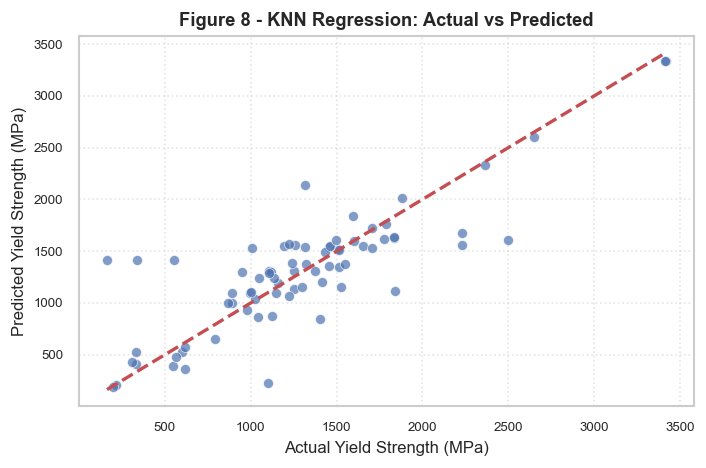

In [145]:
# Visualize actual vs predicted values
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_knn, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)

# Axis labels and title
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Actual Yield Strength (MPa)", fontsize=10)
plt.ylabel("Predicted Yield Strength (MPa)", fontsize=10)
plt.title("Figure 8 - KNN Regression: Actual vs Predicted", fontsize=11, weight="bold")

# Grid and layout
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()

# Save and display
plt.savefig("../analysis/figures/Fig08_KNN_Actual_vs_Predicted.png", dpi=300)
plt.show()

### 3.6. XGBoost
Finally, we implement **XGBoost** to provide predictive power with interpretability.

In [146]:
# XGBoost pipeline
xgb_pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBRegressor(random_state=15, eval_metric="rmse"))
])

# Hyperparameter grid
xgb_params = {
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.01, 0.1, 0.2],
    "xgb__n_estimators": [100, 200]
}

# Grid search
xgb_search = GridSearchCV(xgb_pipe, xgb_params, cv=cv)
xgb_search.fit(X_train, y_train)

# Evaluate
y_pred_xgb = xgb_search.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = root_mean_squared_error(y_test, y_pred_xgb)
print(f"Best params: {xgb_search.best_params_}")
print(f"R²: {r2_xgb:.3f}, RMSE: {rmse_xgb:.1f} MPa")

Best params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 5, 'xgb__n_estimators': 100}
R²: 0.821, RMSE: 268.3 MPa


XGBoost performed better than KNN, explaining **82.1%** of variance. Its **actual vs predicted values** are shown in Figure 9.

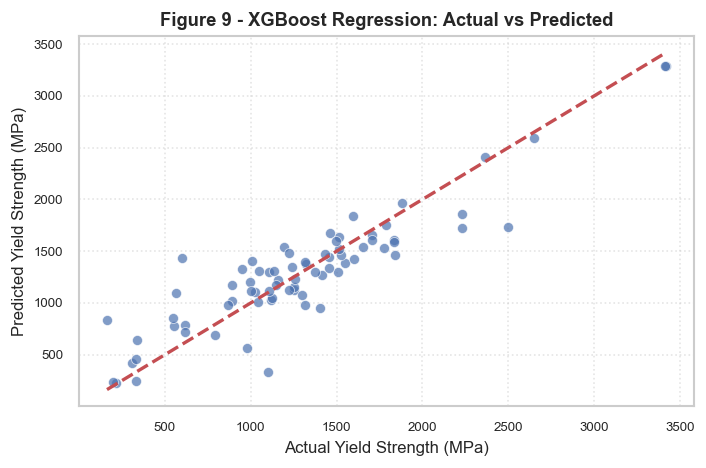

In [147]:
# Visualize actual vs predicted values
plt.figure(figsize=(6, 4))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)

# Axis labels and title
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Actual Yield Strength (MPa)", fontsize=10)
plt.ylabel("Predicted Yield Strength (MPa)", fontsize=10)
plt.title("Figure 9 - XGBoost Regression: Actual vs Predicted", fontsize=11, weight="bold")

# Grid and layout
plt.grid(True, linestyle=":", alpha=0.5)
plt.tight_layout()

# Save and display
plt.savefig("../analysis/figures/Fig09_XGBoost_Actual_vs_Predicted.png", dpi=300)
plt.show()

### 3.7. Model Comparison

The table below summarizes the **performance of regression models** trained to predict yield strength, highlighting XGBoost’s superior accuracy compared to the Ridge and KNN models.

| Model       | R²    | RMSE (MPa) | Key Advantage                          |
|:------------|:------|:---------|----------------------------------------|
| **Ridge**   | 0.485 |    454.4 | Simple, interpretable baseline         |
| **KNN**     | 0.690 |    352.3 | Captures local similarity patterns     |
| **XGBoost** | 0.821 |    268.3 | Best predictive performance + feature importance analysis |


#### 3.8. SHAP Analysis: Interpreting Model Predictions
Now let's use **SHAP (SHapley Additive exPlanations)** to understand how features influence predictions in our XGBoost model. SHAP values provide insights by quantifying each feature's contribution to the model's output. This is critical in materials science, where identifying key drivers of yield strength helps guide alloy design.  

The code below:
1. Extracts the best-trained XGBoost model from the pipeline.
2. Computes SHAP values for all test samples.
3. Generates a **summary plot** showing feature importance ranked by the magnitude of their SHAP values.

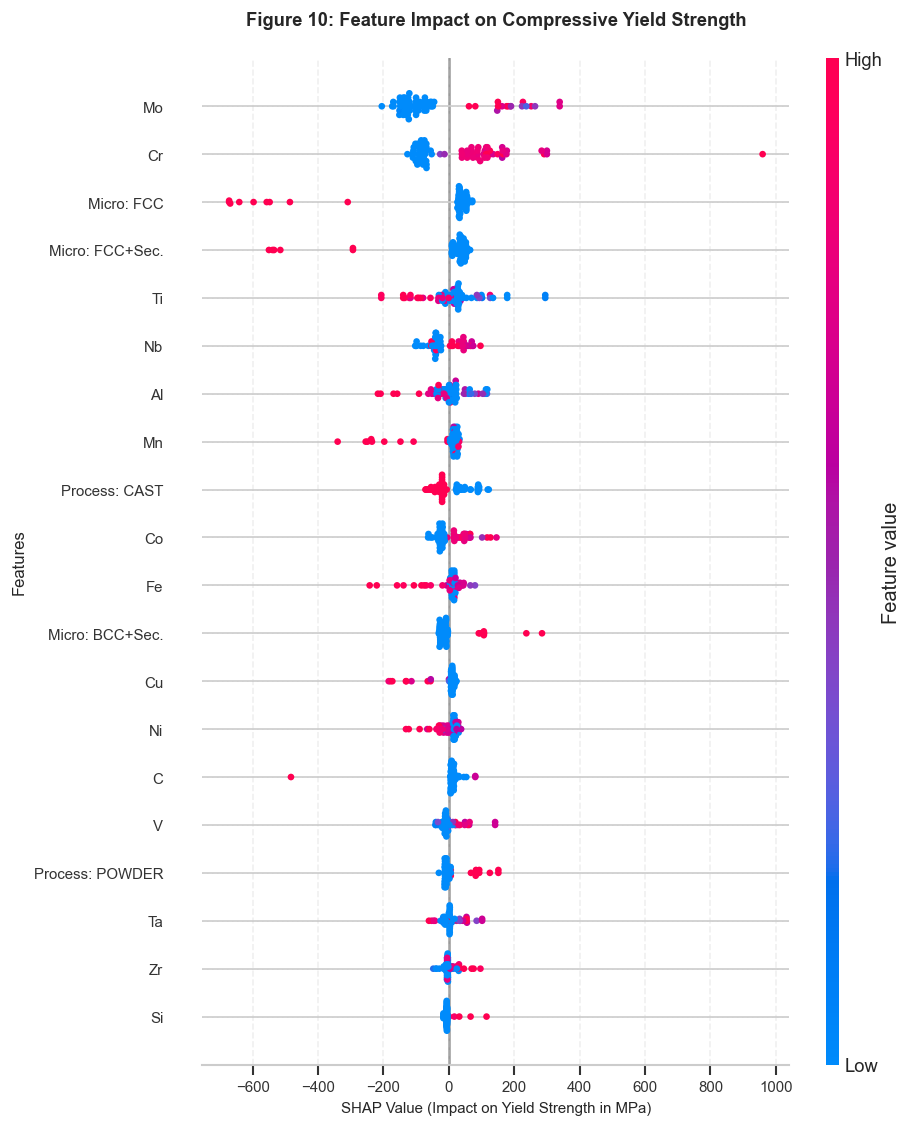

In [152]:
# Extract the best XGBoost model from the pipeline
best_xgb = xgb_search.best_estimator_.named_steps["xgb"]
preprocessor = xgb_search.best_estimator_.named_steps["preprocessor"]

# Preprocess test data
X_test_preprocessed = preprocessor.transform(X_test)

# Generate SHAP values
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_preprocessed)

# Clean feature names
def clean_feature_names(feature_names):
    cleaned = []
    for name in feature_names:
        if name.startswith("Microstructure_"):
            cleaned.append(name.replace("Microstructure_", "Micro: "))
        elif name.startswith("Processing Method_"):
            cleaned.append(name.replace("Processing Method_", "Process: "))
        else:
            cleaned.append(name)
    return cleaned

feature_names = numerical_features + list(preprocessor.named_transformers_["cat"].get_feature_names_out())
clean_names = clean_feature_names(feature_names)

# Plot SHAP summary
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values, 
    X_test_preprocessed, 
    feature_names=clean_names,
    plot_type="dot",
    show=False,
    max_display=20
)

# Customize the plot
plt.title("Figure 10: Feature Impact on Compressive Yield Strength", 
          fontsize=11, weight="bold", pad=20)
plt.xlabel("SHAP Value (Impact on Yield Strength in MPa)", fontsize=9)
plt.ylabel("Features", fontsize=10)

# Adjust tick font sizes
ax = plt.gca()
ax.tick_params(axis="x", labelsize=9)
ax.tick_params(axis="y", labelsize=9)

plt.gca().xaxis.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

# Save and display
plt.savefig("../analysis/figures/Fig10_SHAP.png", dpi=300, bbox_inches="tight")
plt.show()

In Figure 10, each point represents how a feature value affects a prediction:  
- **Color** shows the **feature's magnitude**:  
  - Red = presence/high value  
  - Blue = absence/low value  
- **X-axis position** shows **direction of impact**:  
  - Right = increases yield strength  
  - Left = decreases yield strength  
- **Vertical ordering**: Features are sorted by overall importance (most influential at the top).  

#### Key Insights:

- **Molybdenum (Mo)** and **Chromium (Cr)** are the **most influential features**:  
  - Higher Mo/Cr concentrations usually increase predicted strength  
  - Low Mo/Cr content pulls predictions downward  
- **Microstructure matters**:  
  - Presence of **FCC phases** often reduces strength predictions  
  - Microstructures like **BCC+Sec.** are associated with increased strength  
- **Processing methods influence strength**:  
  - **CAST** processing tends to **decrease strength**  
  - **POWDER** processing usually has a **positive effect**  
- Other elements such as **Ti**, **Al**, and **Fe** show more variable behavior

This analysis confirms that the model captures **composition-process-microstructure relationships** that align with materials science expectations, offering interpretable insights into what makes an alloy strong.

---

## 4. Conclusion

This project demonstrates how EDA and machine learning can extract valuable insights from the **multi-principal element alloy (MPEA) dataset**.  
After thorough validation and filtering, a clean subset of 375 records was obtained, focusing exclusively on **compressive yield strength at 25°C** to ensure consistency. Using only **chemical composition**, **processing method**, and **microstructure**, we achieved an **XGBoost model with R² = 0.821**—a strong result given the complexity of material behavior. The model was not only **predictive** but also **interpretable**, highlighting how data-driven methods can support alloy design in real-world scenarios.

### 4.1 Key Achievements

1. **Identification of High-Strength Alloys**  
   - The **top 15 alloys** with exceptional yield strength were identified (see tables `top_15_yield_strength.csv` and `top15_strength_to_weight.csv` in `data/processed/`). These candidates align with domain knowledge, dominated by **BCC+Sec.**, **BCC+B2**, and **BCC+Laves**  microstructures.  
   - Two `Cr1 Mo1 Nb1 Ta1 V1 W1` alloys (BCC+Laves+Sec, POWDER processed) exceeded **3400 MPa**—a remarkable strength rivaling advanced ceramics.
<br><br>
2. **Predictive Model Performance**  
   - The **XGBoost** model outperformed Ridge Regression and KNN, proving that non-linear relationships between composition, microstructure, and strength can be captured even with targeted subsetting.  
   - **SHAP** analysis confirmed **Mo (Molybdenum)** and **Cr (Chromium)** as the most influential elements
   - **BCC+Sec.** microstructures and **POWDER** processing methods drove high-strength predictions, while **FCC** phases tended to reduce strength.


### 4.2. Limitations and Future Opportunities

This study only scratches the surface of what can be achieved using this extraordinarily rich dataset:
- The analysis focused exclusively on **compressive yield strength** at **room temperature**; many other dimensions remain unexplored, such as **tensile strength**, **temperature dependence**, or **strain-rate effects**.
- The workflow—data cleaning, feature engineering, and SHAP interpretability—can be applied to other material properties (e.g., **hardness, UTS**). 
- **Grain size**, known to influence strength, was excluded due to missing data, but could be explored in a dedicated subset analysis.

### 4.3. Final Thoughts

This project demonstrates that even with a modest subset of data (by ML standards), **substantial predictive power** and **scientific insight** can be achieved—especially when guided by domain understanding and careful data curation. 

**Deep thanks to the authors and contributors of the MPEA dataset**, and to **Citrine Informatics** for their commitment to open materials data. Their work not only advances research—it empowers learners, engineers, and scientists around the world.

---